<a href="https://colab.research.google.com/github/dc3347/CompAspectsofRobotics/blob/main/Robotics_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem 3: Potential Functions


In [2]:
# part a: generate a plot of the potential function using a mesh in the range q1∈[−5,5], q2∈[−5,5]. 

In [3]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import math
import random
from scipy import optimize
import sympy
from sympy import *
from sympy.vector import gradient


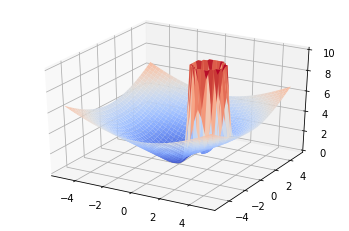

In [4]:

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5.25, 0.25)
Y = np.arange(-5, 5.25, 0.25)
X, Y = np.meshgrid(X, Y)

d = np.sqrt(X**2 + Y**2)

# let 𝑑_𝑖(𝑞) be distance from 𝑞 to closest point on obstacle 𝑖
d_i = np.abs(np.subtract(np.sqrt((X-2)**2+Y**2), 1))
np.clip(d_i, 0.05, 12, d_i)


# attractive potential
U_a = np.piecewise(d, [d<=1, d>1], [lambda d: np.multiply(1/2, d**2), lambda d: np.subtract(d, 1/2)])

# repulsive potential
U_r = np.piecewise(d_i, [d_i<=1, d_i>1], [lambda d_i: np.multiply(1/2, np.subtract(np.divide(1,d_i), 1)**2), lambda d_i: 0])

# total potential
Z = np.add(U_a, U_r)
np.clip(Z, -2, 10, Z)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

# Customize the z axis.
ax.set_zlim(0, 10)

plt.show()

Part 4: Path Planning


In [5]:
# part 1: generate image of C-Space and the path taken by robot

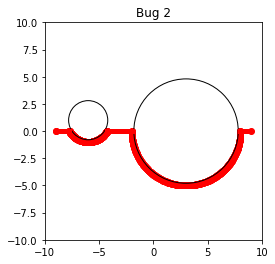

In [6]:
# Change inputs here to run program
#input = [((-1,0),1),((-6,1),2), ((3,2),3)]
#input = [((-1,-1),2),((-6,1),2), ((3,0),1)]
input = [((3,0),5), ((-6,1),2)]


# initializing start, goal, plot
Q_start = -9
Q_goal = 9
toPlotX = []
toPlotX.append(Q_start)

# for storing hit and leave points
leave = [Q_start]
hit = []

#for circle boundary
boundX = []
boundY = []

# iterate through each obstacle
for obstacle in input:
  a = obstacle[0][0] 
  b = obstacle[0][1]
  r = obstacle[1]
  theta = np.linspace(0, 2*np.pi, 1000)  
  
  # distance from point to center of obstacle
  dist = np.sqrt(np.add((X-a)**2, b**2))

  for i in dist:
    for elem in i:
      if (elem < r):
        x =(r*np.cos(theta))+a # x-coord of circle
        y = (r*np.sin(theta))+b # y-coord of circle
        leave.append(float(abs(math.sqrt(r**2 - b**2)) + a))
        hit.append(float((-1)*abs(math.sqrt(r**2 - b**2)) + a)) 
  
  left = bool(random.getrandbits(1))
  if left:
    #print("left")
    for i in range(len(x)):
      if y[i]>0:
        # add points to boundary
        boundX.append(x[i])
        boundY.append(y[i])
  elif not left:
    #print("right")
    for i in range(len(x)):
      if y[i]<0:
        # add points to boundary
        boundX.append(x[i])
        boundY.append(y[i])

# adding the goal as the last hit point
hit.append(Q_goal)

fig, ax = plt.subplots()

# process and sort the data
hit = list(set(hit))
hit.sort()
leave = list(set(leave))
leave.sort()

for i in range(0, len(leave)):
  mline =[leave[i]]
  mline.append(hit[i])
  #print(mline)
  yline=[0 for i in mline]
  ax.plot(mline,yline,color='red', linewidth=5.0)

# adds points to be plotted
toPlotX += hit + leave 
toPlotY = [0 for i in toPlotX]
toPlotX += boundX
toPlotY += boundY

ax.scatter(toPlotX, toPlotY, color = "red") 
ax.set_title("Bug 2") 

ax.set_aspect(1)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

# adds all the obstacles to the input
for obstacle in input:
  ax.add_patch(plt.Circle(Point(obstacle[0][0],obstacle[0][1]),obstacle[1]-0.2, fill = False))

plt.show() 


In [7]:
# part 2

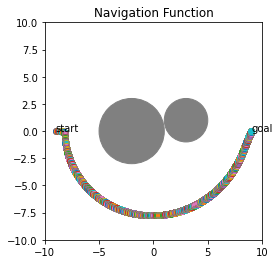

In [33]:
# Try number 2

# 1) start by programming navigation function given obstacles

input = [((-2,0),3), ((3,1),2)]
#input = [((-2,0),1), ((3,1),1)]
#input = [((-3,0),1), ((5,-2),3)]

# Make data.
X = np.linspace(-10, 10.25, 200)
Y = np.linspace(-10, 10.25, 200)
X, Y = np.meshgrid(X, Y)

#fig = plt.figure()
#ax = fig.gca(projection='3d')

fig,ax = plt.subplots()
Q_start = -9
Q_goal = 9
plt.scatter([Q_start,Q_goal],[0,0], color = 'red')
plt.text(Q_start, 0, "start")
plt.text(Q_goal, 0, "goal")
ax.set_aspect(1)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

# dist to goal
d_phi_qgoal = np.sqrt((X-9)**2 + Y**2)

# dist to center of C-space
d_B_q0 = np.sqrt(X**2 + Y**2)

# radius of C-space
r_0 = 10

# kappa
k = 1

# calculating summation for B
for obstacle in input:
  r_i = obstacle[1] #obstacles radius
  x_obs = obstacle[0][0]
  y_obs = obstacle[0][1]

  ax.add_patch(plt.Circle(Point(x_obs,y_obs),r_i, color = 'grey'))
  # dist to center of obstacle
  d_B_qi = np.sqrt((X-x_obs)**2 + (Y-y_obs)**2)

  mult = np.subtract(d_B_qi**2, r_i**2)

B = np.multiply((-1*d_B_q0**2 + r_0**2), mult)

# calculating phi and plotting the navigation function
phi = np.divide(d_phi_qgoal**2, np.add(d_phi_qgoal**(2*k), B)**(1/k))
ax.set_title('Navigation Function')
levels = np.arange(-10,10,0.1)
#plt.contour(X, Y, phi, levels, colors='black')


# 2) Take the gradient of phi
q_x, q_y = symbols('q_x q_y')
mul=1
for obstacle in input:
  r_i = obstacle[1] #obstacles radius
  x_obs = obstacle[0][0]
  y_obs = obstacle[0][1]
  inMul = sqrt((q_x-x_obs)**2 + (q_y-y_obs)**2)
  mul *= np.subtract(inMul**2, r_i**2)

beta = (-1*(q_x**2 + q_y**2) + r_0**2)* mul
f = (sqrt((q_x-9)**2 + q_y**2)**2)/((sqrt((q_x-9)**2 + q_y**2)**(2*k) + beta)**(1/k))
grad_f = lambdify((q_x, q_y), derive_by_array(f, (q_x, q_y)))   # lambda from an expression for graduent

epsilon = 0
alpha = 50
vector = Matrix([-9, 0])  
max_i = 10000

# 3) Do gradient descent
for i in range(max_i):
    grad_value = Matrix(grad_f(vector[0], vector[1]))
    vector -= alpha*grad_value
    plt.scatter(vector[0],vector[1]) #plots path
    if grad_value.norm() <= epsilon:  
        break          
